# Easy Money Purchase Propensity Model

## 1. Imports

### 1.1. Libraries

In [1]:

import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import sklearn
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import joblib


set_config(transform_output = 'pandas')

### 1.2. Data

#### 1.2.1. Preprocessing 1

In [2]:
em_propensity_dc = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_dc')
em_propensity_emc = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_emc')
em_propensity_ltd = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_ltd')
em_propensity_pp = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_pp')

#### 1.2.2. Preprocessing 2

In [3]:
em_propensity_dc_ = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_dc_')
em_propensity_emc_ = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_emc_')
em_propensity_ltd_ = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_ltd_')
em_propensity_pp_ = pd.read_pickle('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/pickles/em_propensity_pp_')

### 1.3. Custom functions

In [4]:
# Validation strategy

def validation_strategy_cl(dataframe, TARGET):
    X_train_, X_val, y_train_, y_val = train_test_split(dataframe.drop(TARGET, axis=1), dataframe[TARGET], test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size = 0.20, random_state = 52)
    return X_train, X_test, y_train, y_test, X_val, y_val

# Predictions

def predictions_cl(X_test, y_test, X_val, y_val, Algorithm, target):
    y_test_pred = pd.DataFrame(Algorithm.predict(X_test), index=y_test.index, columns=[target])
    acc_test = Algorithm.score(X_test, y_test)
    acc_val = Algorithm.score(X_val, y_val)
    f1 = f1_score(y_test, y_test_pred)
    y_proba = Algorithm.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    return print(f'Accuracy test: {round(acc_test, 3)}, Accuracy validation: {round(acc_val, 3)}, F1 score: {round(f1, 3)}, AUC: {round(auc, 3)}')

def xgb_predictions_cl(X_test, y_test, X_val, y_val, Algorithm, target):
    # Convertir conjuntos de datos a DMatrix
    dtest = xgb.DMatrix(X_test)
    dval = xgb.DMatrix(X_val)
    
    # Hacer predicciones
    y_test_pred = Algorithm.predict(dtest)
    
    # Calcular métricas
    f1 = f1_score(y_test, y_test_pred)
    y_proba = Algorithm.predict(dtest)
    auc = roc_auc_score(y_test, y_proba)
    
    # Mostrar resultados
    print(f'F1 score: {round(f1, 3)}, AUC: {round(auc, 3)}')

# Painting predictions

def paint_confusion_matrix(X_test, y_test, algorithm):
    y_pred = algorithm.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    return plt.show()

def paint_roc_curve(X_test, y_test, algorithm):
    y_proba = algorithm.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

def models_comparison_roc_curve(X_train, y_train, X_test, y_test, model_1, model_2, model_3):

    models = [ 
        (model_1),
        (model_2),
        (model_3)
    ]
    plt.clf()
    for model in models:
        model_name = model[0]
        model_instance = model[1]
        model_instance.fit(X_train, np.ravel(y_train))
        predictions = model_instance.predict_proba(X_test)[:,1]
        auc_score = metrics.roc_auc_score(y_test, predictions)
        print('ROC AUC Score for {}: {}'.format(model_name, round(auc_score, 3)))
        fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
        plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    return plt.show()


## 2. Modeling

### 2.1. Targets

In [5]:
TARGET_DC = 'debit_card'
TARGET_PP = 'pension_plan'
TARGET_EMC = 'emc_account'
TARGET_LTD = 'long_term_deposit'

In [6]:
#em_propensity_ltd[TARGET_LTD].value_counts(normalize = True)
em_propensity_dc[TARGET_DC].value_counts(normalize = True)
#em_propensity_emc[TARGET_EMC].value_counts(normalize = True)
#em_propensity_pp[TARGET_PP].value_counts(normalize = True)

debit_card
0    0.846679
1    0.153321
Name: proportion, dtype: float64

### 2.2. Validation strategy

In [7]:
X_train, X_test, y_train, y_test, X_val, y_val = validation_strategy_cl(em_propensity_dc, TARGET_DC)

In [8]:
print(f'Xtrain: {X_train.shape}, Xtest: {X_test.shape}, Xval: {X_val.shape}')

Xtrain: (391569, 50), Xtest: (97893, 50), Xval: (122366, 50)


In [9]:
print(f'ytrain: {y_train.shape}, ytest: {y_test.shape}, yval: {y_val.shape}')

ytrain: (391569,), ytest: (97893,), yval: (122366,)


### 2.3. Testing algorithms

#### 2.3.1. Decision Tree Clasifier

##### 2.3.1.1. RandomizedSearchCV

In [10]:
'''
param_grid = {
    'max_depth': np.arange(2, 15),
    'min_samples_leaf': [50, 100, 250, 400, 550, 700, 850, 1000, 1100, 2000]
}

dt = DecisionTreeClassifier()
cv = RepeatedKFold()

st = time.time()

rand_cv = RandomizedSearchCV(
    estimator = dt,
    param_distributions = param_grid,
    cv = cv,
    return_train_score = True,
    verbose = False,
    n_jobs = -1
)

rand_cv.fit(X_train, y_train)
score_rand = rand_cv.score(X_train, y_train)

et = time.time()

tt_rand = round((et - st)/60, 2)
print("Total time took: ", str(tt_rand), " minutes!")

'''

'\nparam_grid = {\n    \'max_depth\': np.arange(2, 15),\n    \'min_samples_leaf\': [50, 100, 250, 400, 550, 700, 850, 1000, 1100, 2000]\n}\n\ndt = DecisionTreeClassifier()\ncv = RepeatedKFold()\n\nst = time.time()\n\nrand_cv = RandomizedSearchCV(\n    estimator = dt,\n    param_distributions = param_grid,\n    cv = cv,\n    return_train_score = True,\n    verbose = False,\n    n_jobs = -1\n)\n\nrand_cv.fit(X_train, y_train)\nscore_rand = rand_cv.score(X_train, y_train)\n\net = time.time()\n\ntt_rand = round((et - st)/60, 2)\nprint("Total time took: ", str(tt_rand), " minutes!")\n\n'

In [11]:
'''
pd.DataFrame(
            data = list(rand_cv.best_params_.values()) + [round(score_rand, 3)], 
            index = list(rand_cv.best_params_.keys()) + ["Score"],
            columns = ["RandomizedSearchCV"]
        )

'''

'\npd.DataFrame(\n            data = list(rand_cv.best_params_.values()) + [round(score_rand, 3)], \n            index = list(rand_cv.best_params_.keys()) + ["Score"],\n            columns = ["RandomizedSearchCV"]\n        )\n\n'

In [12]:
'''
final_dt = rand_cv
final_dt.best_estimator_
'''

'\nfinal_dt = rand_cv\nfinal_dt.best_estimator_\n'

##### 2.3.1.2. Predictions

In [13]:
#final_dt.fit(X_train, y_train)

In [14]:
dt = DecisionTreeClassifier(max_depth=13, min_samples_leaf=100,random_state=42,)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=100, random_state=42)

In [15]:
predictions_cl(X_test, y_test, X_val, y_val, dt, TARGET_DC)

Accuracy test: 0.947, Accuracy validation: 0.949, F1 score: 0.829, AUC: 0.981


In [16]:
y_pred = dt.predict(X_test)
pd.crosstab(y_test, y_pred)
#(max_depth=10, min_samples_leaf=1000,random_state=42,)

col_0,0,1
debit_card,,
0,80202,2584
1,2570,12537


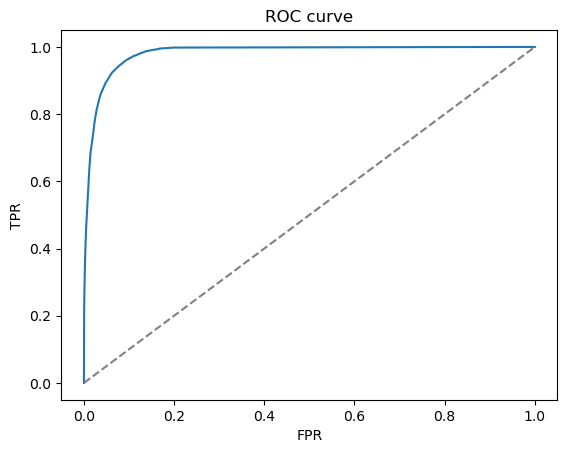

In [19]:
paint_roc_curve(X_test, y_test, dt)

#### 2.3.2. Random Forest

##### 2.3.2.1. RandomizeSearchCV

In [20]:
'''
param_grid = {
    'max_depth': np.arange(2, 15),
    'n_estimators': [50, 100, 150, 200, 250]
}

rf = RandomForestClassifier()
cv = KFold()

st = time.time()

rand_cv = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    cv = cv,
    return_train_score = True,
    verbose = False,
    n_jobs = -1
)

rand_cv.fit(X_train, y_train)
score_rand = rand_cv.score(X_train, y_train)

et = time.time()

tt_rand = round((et - st)/60, 2)
print("Total time took: ", str(tt_rand), " minutes!")
pd.DataFrame(
            data = list(rand_cv.best_params_.values()) + [round(score_rand, 3)], 
            index = list(rand_cv.best_params_.keys()) + ["Score"],
            columns = ["RandomizedSearchCV"]
        )
'''

'\nparam_grid = {\n    \'max_depth\': np.arange(2, 15),\n    \'n_estimators\': [50, 100, 150, 200, 250]\n}\n\nrf = RandomForestClassifier()\ncv = KFold()\n\nst = time.time()\n\nrand_cv = RandomizedSearchCV(\n    estimator = rf,\n    param_distributions = param_grid,\n    cv = cv,\n    return_train_score = True,\n    verbose = False,\n    n_jobs = -1\n)\n\nrand_cv.fit(X_train, y_train)\nscore_rand = rand_cv.score(X_train, y_train)\n\net = time.time()\n\ntt_rand = round((et - st)/60, 2)\nprint("Total time took: ", str(tt_rand), " minutes!")\npd.DataFrame(\n            data = list(rand_cv.best_params_.values()) + [round(score_rand, 3)], \n            index = list(rand_cv.best_params_.keys()) + ["Score"],\n            columns = ["RandomizedSearchCV"]\n        )\n'

In [21]:
#final_rf = rand_cv
#final_rf.best_estimator_

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

##### 2.3.2.2. Predictions

In [23]:
predictions_cl(X_test, y_test, X_val, y_val, rf, TARGET_DC)

Accuracy test: 0.944, Accuracy validation: 0.946, F1 score: 0.824, AUC: 0.979


In [24]:
#y_pred = final_rf.predict(X_test)
#pd.crosstab(y_test, y_pred)  #(n_estimators=100, max_depth=12, random_state=42)

In [25]:
y_pred = rf.predict(X_test)
pd.crosstab(y_test, y_pred)  #(n_estimators=100, max_depth=10, random_state=42)

col_0,0,1
debit_card,,
0,79618,3168
1,2289,12818


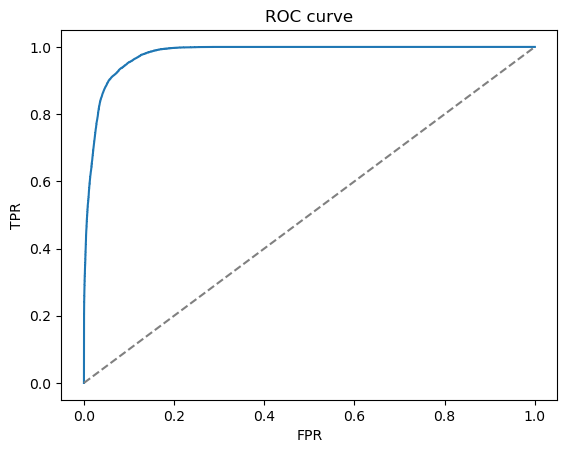

In [26]:
paint_roc_curve(X_test, y_test, rf)

#### 2.3.3. XGBoost

In [ ]:
param_grid = {
    'objective': ['binary:logistic'],
    'eta': [0.1, 0.2, 0.3, 0.4],
    'max_depth': np.arange(2, 15),
    'silent': [1],
    'nthread': [2, 3, 4, 5, 6],
    'eval_metric': ['auc']
}

# Inicializar el modelo XGBoost
xgb_model = xgb.XGBClassifier()

# Inicializar la validación cruzada
cv = KFold()

# Iniciar el tiempo
st = time.time()

# Realizar la búsqueda de hiperparámetros
rand_cv = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    cv=cv,
    return_train_score=True,
    verbose=False,
    n_jobs=-1
)

# Ajustar el modelo a los datos de entrenamiento
rand_cv.fit(X_train, y_train)

# Calcular el puntaje del modelo en los datos de entrenamiento
score_rand = rand_cv.score(X_train, y_train)

# Detener el tiempo
et = time.time()

# Calcular el tiempo total
tt_rand = round((et - st) / 60, 2)
print("Total time took: ", str(tt_rand), " minutes!")

# Mostrar los mejores parámetros encontrados y el puntaje
pd.DataFrame(
    data=list(rand_cv.best_params_.values()) + [round(score_rand, 3)],
    index=list(rand_cv.best_params_.keys()) + ["Score"],
    columns=["RandomizedSearchCV"]
)

# Una vez que tienes los mejores parámetros, puedes entrenar el modelo final con estos parámetros
best_params = rand_cv.best_params_
xgb_model_final = xgb.XGBClassifier(**best_params)
xgb_model_final.fit(X_train, y_train)

In [28]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_val = xgb.DMatrix(X_val, label=y_val)
xgb_test = xgb.DMatrix(X_test, label=y_test)

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['eval_metric'] = 'auc'
watchlist = [(xgb_train, 'train'), (xgb_val, 'val')]
#num_boost_round = 400
num_boost_round = 65

In [29]:
xgb_model = xgb.train(params=param, dtrain=xgb_train, num_boost_round=num_boost_round, evals=watchlist)

[0]	train-auc:0.98280	val-auc:0.98193
[1]	train-auc:0.98369	val-auc:0.98277
[2]	train-auc:0.98402	val-auc:0.98299
[3]	train-auc:0.98421	val-auc:0.98315
[4]	train-auc:0.98443	val-auc:0.98327
[5]	train-auc:0.98457	val-auc:0.98339
[6]	train-auc:0.98477	val-auc:0.98352
[7]	train-auc:0.98489	val-auc:0.98359
[8]	train-auc:0.98501	val-auc:0.98363
[9]	train-auc:0.98510	val-auc:0.98368
[10]	train-auc:0.98520	val-auc:0.98372
[11]	train-auc:0.98528	val-auc:0.98376
[12]	train-auc:0.98539	val-auc:0.98383
[13]	train-auc:0.98550	val-auc:0.98389
[14]	train-auc:0.98560	val-auc:0.98392
[15]	train-auc:0.98570	val-auc:0.98399
[16]	train-auc:0.98576	val-auc:0.98400
[17]	train-auc:0.98584	val-auc:0.98403
[18]	train-auc:0.98589	val-auc:0.98405
[19]	train-auc:0.98597	val-auc:0.98408
[20]	train-auc:0.98604	val-auc:0.98409
[21]	train-auc:0.98612	val-auc:0.98413
[22]	train-auc:0.98619	val-auc:0.98415
[23]	train-auc:0.98625	val-auc:0.98418
[24]	train-auc:0.98634	val-auc:0.98422
[25]	train-auc:0.98638	val-auc:0.98

In [30]:
y_pred_xgb = xgb_model.predict(xgb_test)
y_pred_val_xgb = xgb_model.predict(xgb_val)

print('AUC del XGBoost en el Dataset de Validación: {:.4f}'.format(roc_auc_score(y_val, y_pred_val_xgb)))
print('AUC del XGBoost en el Dataset de Test: {:.4f}'.format(roc_auc_score(y_test, y_pred_xgb)))

AUC del XGBoost en el Dataset de Validación: 0.9848
AUC del XGBoost en el Dataset de Test: 0.9837


In [31]:
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]
y_val_binary = [1 if p >= 0.5 else 0 for p in y_pred_val_xgb]
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     82786
           1       0.83      0.84      0.84     15107

    accuracy                           0.95     97893
   macro avg       0.90      0.90      0.90     97893
weighted avg       0.95      0.95      0.95     97893



In [32]:
pd.crosstab(y_test, y_pred_binary)

col_0,0,1
debit_card,,
0,80248,2538
1,2457,12650


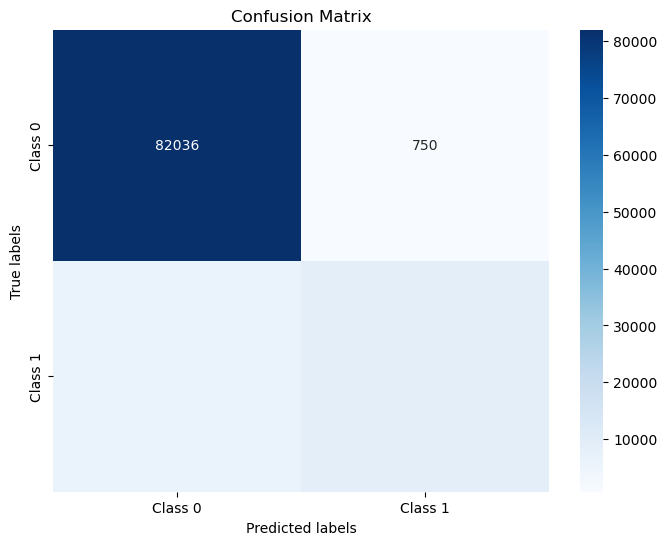

In [33]:
def xgb_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Suponiendo que ya tienes tu modelo XGBoost entrenado y los datos de prueba X_test, y_test
dtest = xgb.DMatrix(X_test)
y_pred = xgb_model.predict(dtest)
y_pred_binary = np.where(y_pred > 0.8, 1, 0)
xgb_confusion_matrix(y_test, y_pred_binary, classes=['Class 0', 'Class 1'])

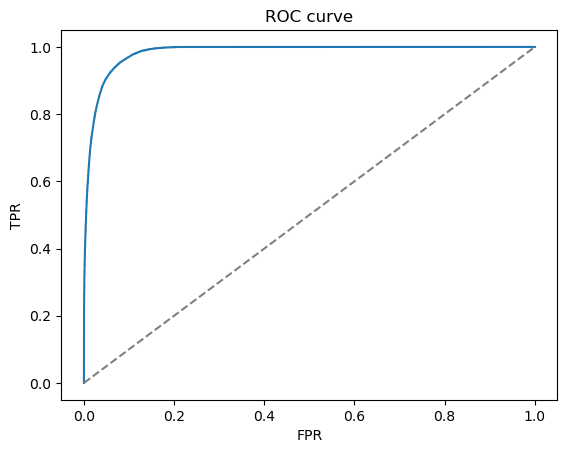

In [34]:
def xgb_paint_roc_curve(X_test, y_test, algorithm):
    dtest = xgb.DMatrix(X_test)
    y_proba = algorithm.predict(dtest, output_margin=True)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()


xgb_paint_roc_curve(X_test, y_test, xgb_model)

#### 2.3.4. Logistic Regresion

In [35]:
lg = LogisticRegression(solver='liblinear', C = 1.0)
lg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [36]:
predictions_cl(X_test, y_test, X_val, y_val, lg, TARGET_DC)

Accuracy test: 0.846, Accuracy validation: 0.848, F1 score: 0.0, AUC: 0.573


In [37]:
y_pred = lg.predict(X_test)
pd.crosstab(y_test, y_pred)  #(n_estimators=100, max_depth=10, random_state=42)

col_0,0
debit_card,
0,82786
1,15107


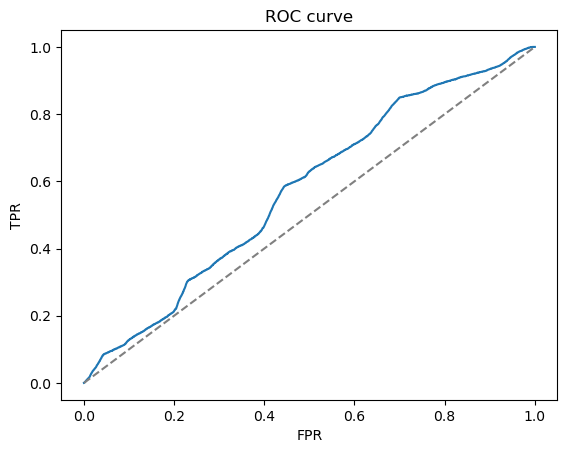

In [38]:
paint_roc_curve(X_test, y_test, lg)

In [39]:
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     82786
           1       0.00      0.00      0.00     15107

    accuracy                           0.85     97893
   macro avg       0.42      0.50      0.46     97893
weighted avg       0.72      0.85      0.77     97893



### 2.4. DEBIT CARD

In [40]:
X_train, X_test, y_train, y_test, X_val, y_val = validation_strategy_cl(em_propensity_dc, TARGET_DC)

#### 2.4.1. Training

In [41]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_val = xgb.DMatrix(X_val, label=y_val)
xgb_test = xgb.DMatrix(X_test, label=y_test)

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['eval_metric'] = 'auc'
watchlist = [(xgb_train, 'train'), (xgb_val, 'val')]
#num_boost_round = 400
num_boost_round = 65

In [42]:
xgb_model_dc = xgb.train(params=param, dtrain=xgb_train, num_boost_round=num_boost_round, evals=watchlist)

[0]	train-auc:0.98280	val-auc:0.98193
[1]	train-auc:0.98369	val-auc:0.98277
[2]	train-auc:0.98402	val-auc:0.98299
[3]	train-auc:0.98421	val-auc:0.98315
[4]	train-auc:0.98443	val-auc:0.98327
[5]	train-auc:0.98457	val-auc:0.98339
[6]	train-auc:0.98477	val-auc:0.98352
[7]	train-auc:0.98489	val-auc:0.98359
[8]	train-auc:0.98501	val-auc:0.98363
[9]	train-auc:0.98510	val-auc:0.98368
[10]	train-auc:0.98520	val-auc:0.98372
[11]	train-auc:0.98528	val-auc:0.98376
[12]	train-auc:0.98539	val-auc:0.98383
[13]	train-auc:0.98550	val-auc:0.98389
[14]	train-auc:0.98560	val-auc:0.98392
[15]	train-auc:0.98570	val-auc:0.98399
[16]	train-auc:0.98576	val-auc:0.98400
[17]	train-auc:0.98584	val-auc:0.98403
[18]	train-auc:0.98589	val-auc:0.98405
[19]	train-auc:0.98597	val-auc:0.98408
[20]	train-auc:0.98604	val-auc:0.98409
[21]	train-auc:0.98612	val-auc:0.98413
[22]	train-auc:0.98619	val-auc:0.98415
[23]	train-auc:0.98625	val-auc:0.98418
[24]	train-auc:0.98634	val-auc:0.98422
[25]	train-auc:0.98638	val-auc:0.98

#### 2.4.2. Predictions

In [43]:
y_pred_xgb = xgb_model_dc.predict(xgb_test)
y_pred_val_xgb = xgb_model_dc.predict(xgb_val)

print('AUC del XGBoost en el Dataset de Validación: {:.4f}'.format(roc_auc_score(y_val, y_pred_val_xgb)))
print('AUC del XGBoost en el Dataset de Test: {:.4f}'.format(roc_auc_score(y_test, y_pred_xgb)))

AUC del XGBoost en el Dataset de Validación: 0.9848
AUC del XGBoost en el Dataset de Test: 0.9837


In [44]:
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]
y_val_binary = [1 if p >= 0.5 else 0 for p in y_pred_val_xgb]
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     82786
           1       0.83      0.84      0.84     15107

    accuracy                           0.95     97893
   macro avg       0.90      0.90      0.90     97893
weighted avg       0.95      0.95      0.95     97893



In [45]:
pd.crosstab(y_test, y_pred_binary)

col_0,0,1
debit_card,,
0,80248,2538
1,2457,12650


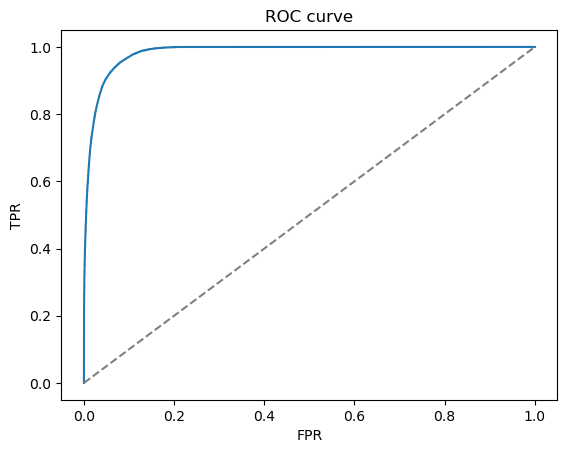

In [46]:
def xgb_paint_roc_curve(X_test, y_test, algorithm):
    dtest = xgb.DMatrix(X_test)
    y_proba = algorithm.predict(dtest, output_margin=True)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()


xgb_paint_roc_curve(X_test, y_test, xgb_model)

#### 2.4.3. Saving model

In [47]:
joblib.dump(xgb_model_dc, 'C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_dc.pkl')

['C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_dc.pkl']

### 2.5. PENSION PLAN

In [48]:
X_train, X_test, y_train, y_test, X_val, y_val = validation_strategy_cl(em_propensity_pp, TARGET_PP)

#### 2.5.1. Resample

In [49]:
undersampler = RandomUnderSampler(sampling_strategy=0.15, random_state=42)


In [50]:
X_train_r, y_train_r = undersampler.fit_resample(X_train, y_train)


#### 2.5.2. Training

In [51]:
xgb_train = xgb.DMatrix(X_train_r, label=y_train_r)
xgb_val = xgb.DMatrix(X_val, label=y_val)
xgb_test = xgb.DMatrix(X_test, label=y_test)

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['eval_metric'] = 'auc'
watchlist = [(xgb_train, 'train'), (xgb_val, 'val')]
#num_boost_round = 400
num_boost_round = 65

In [52]:
xgb_model_pp = xgb.train(params=param, dtrain=xgb_train, num_boost_round=num_boost_round, evals=watchlist)

[0]	train-auc:0.99655	val-auc:0.99601
[1]	train-auc:0.99679	val-auc:0.99620
[2]	train-auc:0.99688	val-auc:0.99629
[3]	train-auc:0.99701	val-auc:0.99635
[4]	train-auc:0.99711	val-auc:0.99642
[5]	train-auc:0.99724	val-auc:0.99650
[6]	train-auc:0.99731	val-auc:0.99654
[7]	train-auc:0.99740	val-auc:0.99656
[8]	train-auc:0.99745	val-auc:0.99657
[9]	train-auc:0.99751	val-auc:0.99659
[10]	train-auc:0.99757	val-auc:0.99660
[11]	train-auc:0.99761	val-auc:0.99660
[12]	train-auc:0.99765	val-auc:0.99661
[13]	train-auc:0.99785	val-auc:0.99667
[14]	train-auc:0.99789	val-auc:0.99668
[15]	train-auc:0.99792	val-auc:0.99669
[16]	train-auc:0.99796	val-auc:0.99670
[17]	train-auc:0.99800	val-auc:0.99671
[18]	train-auc:0.99804	val-auc:0.99672
[19]	train-auc:0.99806	val-auc:0.99672
[20]	train-auc:0.99810	val-auc:0.99674
[21]	train-auc:0.99820	val-auc:0.99679
[22]	train-auc:0.99825	val-auc:0.99679
[23]	train-auc:0.99829	val-auc:0.99680
[24]	train-auc:0.99834	val-auc:0.99681
[25]	train-auc:0.99837	val-auc:0.99

#### 2.5.3. Predictions

In [53]:
y_pred_xgb = xgb_model_pp.predict(xgb_test)
y_pred_val_xgb = xgb_model_pp.predict(xgb_val)

print('AUC del XGBoost en el Dataset de Validación: {:.4f}'.format(roc_auc_score(y_val, y_pred_val_xgb)))
print('AUC del XGBoost en el Dataset de Test: {:.4f}'.format(roc_auc_score(y_test, y_pred_xgb)))

AUC del XGBoost en el Dataset de Validación: 0.9972
AUC del XGBoost en el Dataset de Test: 0.9972


In [54]:
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]
y_val_binary = [1 if p >= 0.5 else 0 for p in y_pred_val_xgb]
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     89876
         1.0       0.86      0.94      0.90      6664

    accuracy                           0.99     96540
   macro avg       0.93      0.97      0.95     96540
weighted avg       0.99      0.99      0.99     96540



In [55]:
pd.crosstab(y_test, y_pred_binary)

col_0,0,1
pension_plan,,
0.0,88855,1021
1.0,384,6280


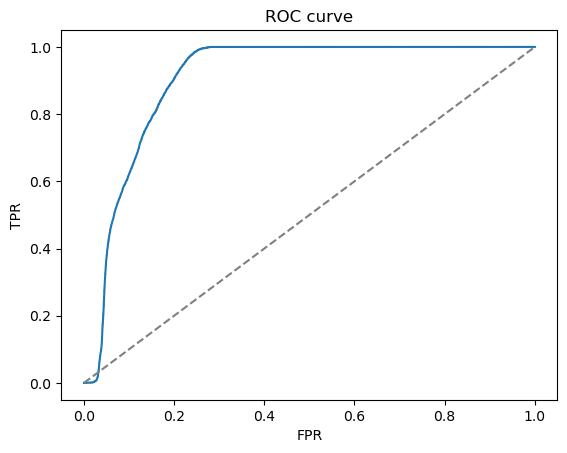

In [56]:
def xgb_paint_roc_curve(X_test, y_test, algorithm):
    dtest = xgb.DMatrix(X_test)
    y_proba = algorithm.predict(dtest, output_margin=True)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()


xgb_paint_roc_curve(X_test, y_test, xgb_model)

#### 2.5.3. Saving model

In [57]:
joblib.dump(xgb_model_pp, 'C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_pp.pkl')

['C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_pp.pkl']

### 2.6. EMC_ACOUNT

In [58]:
X_train, X_test, y_train, y_test, X_val, y_val = validation_strategy_cl(em_propensity_emc, TARGET_EMC)

#### 2.6.1. Resample

In [59]:
undersampler = RandomUnderSampler(sampling_strategy=0.15, random_state=42)


In [60]:
X_train_r, y_train_r = undersampler.fit_resample(X_train, y_train)


#### 2.6.2. Training

In [61]:
xgb_train = xgb.DMatrix(X_train_r, label=y_train_r)
xgb_val = xgb.DMatrix(X_val, label=y_val)
xgb_test = xgb.DMatrix(X_test, label=y_test)

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['eval_metric'] = 'auc'
watchlist = [(xgb_train, 'train'), (xgb_val, 'val')]
#num_boost_round = 400
num_boost_round = 65

In [62]:
xgb_model_emc = xgb.train(params=param, dtrain=xgb_train, num_boost_round=num_boost_round, evals=watchlist)

[0]	train-auc:0.96233	val-auc:0.95939
[1]	train-auc:0.96617	val-auc:0.96316
[2]	train-auc:0.96692	val-auc:0.96372
[3]	train-auc:0.96757	val-auc:0.96426
[4]	train-auc:0.96887	val-auc:0.96526
[5]	train-auc:0.96958	val-auc:0.96582
[6]	train-auc:0.97006	val-auc:0.96622
[7]	train-auc:0.97072	val-auc:0.96676
[8]	train-auc:0.97121	val-auc:0.96712
[9]	train-auc:0.97167	val-auc:0.96742
[10]	train-auc:0.97206	val-auc:0.96765
[11]	train-auc:0.97244	val-auc:0.96790
[12]	train-auc:0.97272	val-auc:0.96807
[13]	train-auc:0.97295	val-auc:0.96817
[14]	train-auc:0.97330	val-auc:0.96839
[15]	train-auc:0.97354	val-auc:0.96858
[16]	train-auc:0.97379	val-auc:0.96867
[17]	train-auc:0.97413	val-auc:0.96883
[18]	train-auc:0.97440	val-auc:0.96898
[19]	train-auc:0.97484	val-auc:0.96922
[20]	train-auc:0.97514	val-auc:0.96941
[21]	train-auc:0.97538	val-auc:0.96951
[22]	train-auc:0.97554	val-auc:0.96960
[23]	train-auc:0.97584	val-auc:0.96974
[24]	train-auc:0.97601	val-auc:0.96983
[25]	train-auc:0.97624	val-auc:0.96

#### 2.6.3. Predictions

In [63]:
y_pred_xgb = xgb_model_emc.predict(xgb_test)
y_pred_val_xgb = xgb_model_emc.predict(xgb_val)

print('AUC del XGBoost en el Dataset de Validación: {:.4f}'.format(roc_auc_score(y_val, y_pred_val_xgb)))
print('AUC del XGBoost en el Dataset de Test: {:.4f}'.format(roc_auc_score(y_test, y_pred_xgb)))

AUC del XGBoost en el Dataset de Validación: 0.9722
AUC del XGBoost en el Dataset de Test: 0.9723


In [64]:
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]
y_val_binary = [1 if p >= 0.5 else 0 for p in y_pred_val_xgb]
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     90267
           1       0.63      0.72      0.67      6963

    accuracy                           0.95     97230
   macro avg       0.80      0.84      0.82     97230
weighted avg       0.95      0.95      0.95     97230



In [65]:
pd.crosstab(y_test, y_pred_binary)

col_0,0,1
emc_account,,
0,87313,2954
1,1964,4999


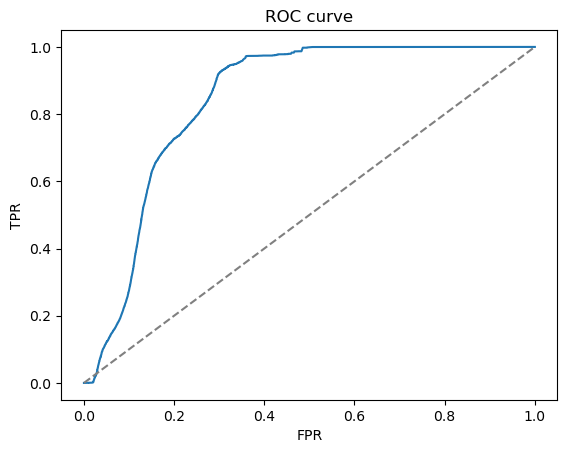

In [66]:
def xgb_paint_roc_curve(X_test, y_test, algorithm):
    dtest = xgb.DMatrix(X_test)
    y_proba = algorithm.predict(dtest, output_margin=True)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()


xgb_paint_roc_curve(X_test, y_test, xgb_model)

#### 2.6.3. Saving model

In [67]:
joblib.dump(xgb_model_emc, 'C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_emc.pkl')

['C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_emc.pkl']

## 3. Purchase propensity

### 3.1. Propensity data

In [68]:
# Loading models
xgb_model_dc = joblib.load('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_dc.pkl')
xgb_model_pp = joblib.load('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_pp.pkl')
xgb_model_emc = joblib.load('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/models/xgb_model_emc.pkl')

In [69]:
dc_prop_cust = em_propensity_dc[em_propensity_dc[TARGET_DC]==0]
emc_prop_cust = em_propensity_emc[em_propensity_emc[TARGET_EMC]==0]
pp_prop_cust = em_propensity_pp[em_propensity_pp[TARGET_PP]==0]

### 3.2. Debit card

In [70]:
'''

cid = dc_prop_cust.drop(TARGET_DC, axis = 1).reset_index()[['pk_cid']]
X = dc_prop_cust.drop(TARGET_DC, axis = 1).reset_index().drop('pk_cid', axis = 1)

X_dmatrix = xgb.DMatrix(X)
dc_predictions = xgb_model_dc.predict(X_dmatrix)

dc_prediction = {'Prediction': dc_predictions}
df_predictions = pd.DataFrame(dc_prediction)

dc_final_df = cid.merge(df_predictions, left_index=True, right_index=True).groupby('pk_cid')['Prediction'].agg(
    Propensity = 'mean')

dc_final_df[dc_final_df['Propensity']> 0.8]

'''

"\n\ncid = dc_prop_cust.drop(TARGET_DC, axis = 1).reset_index()[['pk_cid']]\nX = dc_prop_cust.drop(TARGET_DC, axis = 1).reset_index().drop('pk_cid', axis = 1)\n\nX_dmatrix = xgb.DMatrix(X)\ndc_predictions = xgb_model_dc.predict(X_dmatrix)\n\ndc_prediction = {'Prediction': dc_predictions}\ndf_predictions = pd.DataFrame(dc_prediction)\n\ndc_final_df = cid.merge(df_predictions, left_index=True, right_index=True).groupby('pk_cid')['Prediction'].agg(\n    Propensity = 'mean')\n\ndc_final_df[dc_final_df['Propensity']> 0.8]\n\n"

In [71]:
def propensity_prediction(new_df, target, model, precision_rate):
    cid = new_df.drop(target, axis = 1).reset_index()[['pk_cid']]
    X = new_df.drop(target, axis = 1).reset_index().drop('pk_cid', axis = 1)

    X_dmatrix = xgb.DMatrix(X)
    predictions = model.predict(X_dmatrix)

    prediction = {'Prediction': predictions}
    predictions = pd.DataFrame(prediction)

    final_df = cid.merge(predictions, left_index=True, right_index=True).groupby('pk_cid')['Prediction'].agg(
    Propensity = 'mean')
    final_df = final_df[final_df['Propensity']> precision_rate]
    return final_df

In [72]:
dc_prop_pred = propensity_prediction(dc_prop_cust, TARGET_DC, xgb_model_dc, 0.8)
dc_prop_pred

,Propensity
pk_cid,
31624,0.838497
45850,0.850944
79129,0.887530
94134,0.952826
115885,0.859659
...,...
1536734,0.861269
1538480,0.890766
1542779,0.820246


### 3.3. Pension Plan

In [73]:
pp_prop_pred = propensity_prediction(pp_prop_cust, TARGET_PP, xgb_model_pp, 0.8)
pp_prop_pred

,Propensity
pk_cid,
26163,0.916642
98588,0.852892
192005,0.913880
241192,0.815170
327291,0.846250
...,...
1513829,0.876972
1521989,0.920845
1528839,0.801826


### 3.4. Emc Account

In [74]:
emc_prop_pred = propensity_prediction(emc_prop_cust, TARGET_EMC, xgb_model_emc, 0.8)
emc_prop_pred

,Propensity
pk_cid,
26018,0.808536
63111,0.830486
69575,0.889222
166328,0.828829
174303,0.915197
...,...
1376921,0.857741
1404663,0.838310
1416236,0.862796


### 3.5. Profit

In [75]:
PATH = r'C:\Users\Usuario\Desktop\Proyects\Easy Money\data_compressed'
file_name =  r"\sales.csv"
file_name3 = r"\product_description.csv"
sales = pd.read_csv(PATH + file_name, sep = ",", index_col=0)
prd = pd.read_csv(PATH + file_name3, sep = ",", index_col=0)
#prd

In [76]:
dc_net_margin = sales[sales['product_ID']==3819]['net_margin'].mean()
emc_net_margin = sales[sales['product_ID']==8871]['net_margin'].mean()
pp_net_margin = sales[sales['product_ID']==1364]['net_margin'].mean()

In [77]:
#debit card profit prediction
print('Debit card:',round(len(dc_prop_pred)*dc_net_margin, 2), '€')
#pension plan profit prediction
print('Pension Plan:',round(len(pp_prop_pred)*pp_net_margin, 2), '€')
#emc account profit prediction
print('Emc Account:',round(len(emc_prop_pred)*emc_net_margin, 2), '€')

Debit card: 65883.53 €
Pension Plan: 3203369.65 €
Emc Account: 51319.48 €


In [94]:
data = {
    'Product': ['Debit card', 'Emc acount', 'Pension plan'],
    'Average profit': [round(dc_net_margin, 2), round(emc_net_margin, 2), round(pp_net_margin, 2)],
        'N future customers': [round(len(dc_prop_pred), 2), round(len(emc_prop_pred), 2), round(len(pp_prop_pred), 2)]
}
profit_pred = pd.DataFrame(data)

In [95]:
profit_pred['Total profit - Long Term'] = profit_pred['Average profit']*profit_pred['N future customers']

In [96]:
profit_pred

,Product,Average profit,N future customers,Total profit - Long Term
0,Debit card,60.00,1098,65880.00
1,Emc acount,70.01,733,51317.33
2,Pension plan,5976.44,536,3203371.84


### 3.6. CSVs

In [98]:
dc_prop_pred.to_csv('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/CSVs/dc_prop_pred.csv')
pp_prop_pred.to_csv('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/CSVs/pp_prop_pred.csv')
emc_prop_pred.to_csv('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/CSVs/emc_prop_pred.csv')
profit_pred.to_csv('C:/Users/Usuario/Desktop/Proyects/Easy Money/EasyMoney_/CSVs/profit_pred.csv')